> Martin Fridrich 01/2025

# Waste product classification

## Data

In [1]:
#%pip install -q -r dl-env-requirements.txt

In [2]:
# print out tf version
import tensorflow as tf
print(f"Installed tensorflow version: {tf.__version__}")

2025-01-11 15:03:55.340256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736604235.351133   44206 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736604235.354587   44206 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 15:03:55.367094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Installed tensorflow version: 2.18.0


In [3]:
import os
import zipfile
import requests

class DataUtils():

    # Data download and extraction

    def __init__(self):
        self.data_dir = "data"
        self.data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
        self.data_file = "o-vs-r-split-reduced-1200.zip"
        self.validation_split = 0.2
        self.img_size = (150, 150)
        self.batch_size = 32

    def download_data(self):
        if not os.path.exists(self.data_dir):
            os.makedirs(self.data_dir)
            
        data_path = os.path.join(self.data_dir, self.data_file)
        
        if not os.path.exists(data_path):
            print("Downloading data...")
            response = requests.get(self.data_url)
            with open(data_path, 'wb') as f:
                f.write(response.content)
            
            print("Extracting data...")
            with zipfile.ZipFile(data_path, 'r') as zip_ref:
                zip_ref.extractall(self.data_dir)
            
            #print("Removing zip file...")
            #os.remove(data_path)
            
            print("Data download and extraction completed.")
        else:
            print("Data already exists.")
        
        return self
    # Data generators

    def _get_train_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            validation_split=self.validation_split,
            rescale=1.0/255.0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
    
    def _get_validation_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(
            validation_split=self.validation_split,
            rescale=1.0/255.0)

    def _get_test_augmentation(self):
        return tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    def initialize_data_generators(self):
        train_datagen = self._get_train_augmentation()
        validation_datagen = self._get_validation_augmentation()
        test_datagen = self._get_test_augmentation()

        common_params = {
            'target_size': self.img_size,
            'batch_size': self.batch_size,
            'class_mode': 'binary'
        }

        self.train_generator = train_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/train/"),
            subset="training",
            **common_params)
        
        self.validation_generator = validation_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/train/"),
            subset="validation",
            **common_params)
        
        self.test_generator = test_datagen.flow_from_directory(
            os.path.join(self.data_dir, "o-vs-r-split/test/"),
            **common_params)
        
        return self

data = DataUtils().download_data().initialize_data_generators()
print(f"Train data generator consists of  {len(data.train_generator)} batches.")

Data already exists.
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Train data generator consists of  25 batches.


## Modeling

In [12]:
import matplotlib.pyplot as plt

class Modeling():
    def __init__(self, data):
        self.data = data
        self.model = None
        self.history = None
        self.feature_extractor = None

    def load_feature_extractor(self):
        vgg = tf.keras.applications.VGG16(
            include_top=False,
            weights='imagenet',
            input_shape = data.img_size + (3,))
        vgg.trainable = False

        output = vgg.layers[-1].output
        output = tf.keras.layers.Flatten()(output)
        self.feature_extractor = tf.keras.Model(vgg.input, output)
        return self
    
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=data.img_size + (3,))
        x = self.feature_extractor(inputs, training=False)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        self.model = tf.keras.Model(inputs, outputs)
        return self
    
    def compile_model(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])
        return self
    
    def train_model(self, epochs=10):
        self.history = self.model.fit(
            self.data.train_generator,
            validation_data=self.data.validation_generator,
            epochs=epochs,
            verbose=1)
        return self
    
    def plot_history(self):
        
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.figure()
        plt.plot(epochs, loss, 'r', label='Training Loss')
        plt.plot(epochs, val_loss, 'b', label='Validation Loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
        return self

/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1736604295.624917   44424 service.cc:148] XLA service 0x78167c012550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736604295.625008   44424 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-11 15:04:55.872013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736604296.295551   44424 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/25 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - accuracy: 0.4062 - loss: 1.1974

I0000 00:00:1736604303.325510   44424 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5808 - loss: 0.8408

/mnt/Data/git_root/ibm-ai-engineering/.dl-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.5831 - loss: 0.8363 - val_accuracy: 0.6700 - val_loss: 0.5685
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7435 - loss: 0.5510 - val_accuracy: 0.7900 - val_loss: 0.4467
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.7760 - loss: 0.4522 - val_accuracy: 0.8400 - val_loss: 0.3982
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8182 - loss: 0.4079 - val_accuracy: 0.8550 - val_loss: 0.3501
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8182 - loss: 0.4031 - val_accuracy: 0.8900 - val_loss: 0.3356
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.8092 - loss: 0.4092 - val_accuracy: 0.9000 - val_loss: 0.2804
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8380 - loss: 0.3433 - val_accuracy: 0.8900 - val_loss: 0.2771
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8575 - loss: 0.3428 - val_accuracy: 0.8950 - val_loss

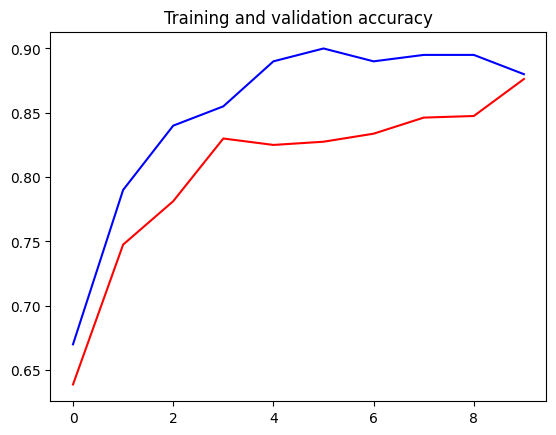

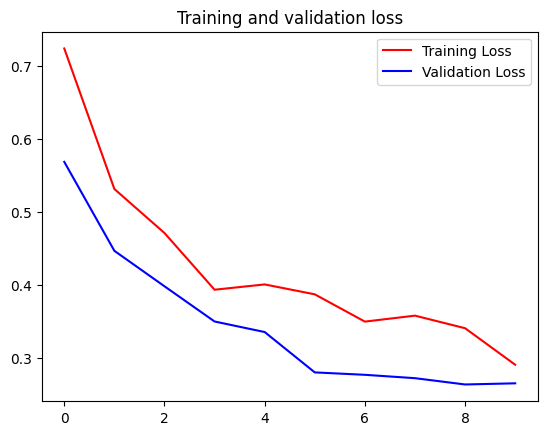

In [ ]:
freezed_model = Modeling(data).load_feature_extractor()\
    .build_model().compile_model().train_model(epochs=10).plot_history()

In [ ]:
# tbd - callbacks
# finetuning and generalization of the current approach
# evaluation on the test set
# plotting examples of correct and incorrect predictions

#